In [89]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

In [90]:
raw_crime_data = pd.read_csv("crimes_-_2022.csv")
raw_crime_data.shape

(239043, 22)

In [91]:
raw_crime_data.isnull().sum()

ID                         0
Case Number                0
Date                       0
Block                      0
IUCR                       0
Primary Type               0
Description                0
Location Description     881
Arrest                     0
Domestic                   0
Beat                       0
District                   0
Ward                      10
Community Area             0
FBI Code                   0
X Coordinate            4107
Y Coordinate            4107
Year                       0
Updated On                 0
Latitude                4107
Longitude               4107
Location                4107
dtype: int64

### Full data preparation
*By Alyssa Shou*

In [92]:
# convert the Date column to datetime object
raw_crime_data.Date.dtypes

dtype('O')

In [93]:
# converting the date column to datetime objects #
raw_crime_data['Date'] = raw_crime_data['Date'].apply(pd.to_datetime)
type(raw_crime_data.Date[0])

pandas._libs.tslibs.timestamps.Timestamp

### Crime type preparation
*By Alyssa Shou*

Since there are 881 NA values in Location Description, I had to drop them because the location of the crimes is necessary for my analysis.

In [94]:
# Dropping a very small percentage of the data so general trends should not change
881/239043

0.0036855293817430338

In [95]:
time_data = raw_crime_data.dropna(subset = ['Location Description'])
time_data.shape

(238162, 22)

### Theft data preparation
*By Grace Chang*

The following data preparation steps served to subset theft data and subsequently merge it with community area data in order to run further analyses on theft occurrence across community areas.

1. Since the community areas in the original dataset are labeled by their numeric code, I merged it with another dataset to pair these codes with their corresponding community names. 

2. In the original dataset, numeric codes needed to be converted to double digits so that the merge could take place. All observations of "The Loop" were also cleaned so that their format was consistent with the rest of the community area names. 

In [96]:
theft_data = raw_crime_data.loc[(raw_crime_data['Primary Type'] == 'THEFT'), :]

In [97]:
community_areas = pd.read_html('https://en.wikipedia.org/wiki/Community_areas_in_Chicago', match = 'Chicago community areas by number, population, and area')
community_areas = community_areas[0]
community_areas.columns = [col[0] for col in community_areas.columns]
community_areas.columns = ["No.", "Community Name", "Population", "Area (sqmi)", "Area (sqkm)", "Density (sqmi)", "Density (sqkm)"]
community_areas.head() # Formatting the Community Areas dataset to prepare it for merging

,No.,Community Name,Population,Area (sqmi),Area (sqkm),Density (sqmi),Density (sqkm)
0,01,Rogers Park,55628,1.84,4.77,30232.61,11672.81
1,02,West Ridge,77122,3.53,9.14,21847.59,8435.36
2,03,Uptown,57182,2.32,6.01,24647.41,9516.37
3,04,Lincoln Square,40494,2.56,6.63,15817.97,6107.32
4,05,North Center,35114,2.05,5.31,17128.78,6613.42


In [98]:
theft_data.loc[:,'Community Area'] = theft_data['Community Area'].apply(lambda x: f'{int(x):02d}' if isinstance(x, (int, str)) and str(x).isdigit() else x)
theft_data['Community Area'].value_counts().head(6) # Checking that the single digit codes were indeed converted to double digit format

08    4251
32    3464
28    3373
24    2681
06    2268
25    1823
Name: Community Area, dtype: int64

In [99]:
theft_data.loc[:,'Community Area'] = theft_data['Community Area'].astype(str)
theft_community_data = theft_data.merge(community_areas, left_on = 'Community Area', right_on = 'No.', how = 'left')
theft_community_data['Community Name'] = theft_community_data['Community Name'].apply(lambda x: x.replace('(The) Loop[11]', 'The Loop'))
theft_community_data.head() # The newly merged dataset with cleaned community names

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Latitude,Longitude,Location,No.,Community Name,Population,Area (sqmi),Area (sqkm),Density (sqmi),Density (sqkm)
0,13209277,JG422539,2022-08-15 09:00:00,0000X W JACKSON BLVD,0810,THEFT,OVER $500,COMMERCIAL / BUSINESS OFFICE,False,False,...,NaN,NaN,NaN,32,The Loop,42298,1.65,4.27,25635.15,9897.73
1,12678035,JF216671,2022-04-22 23:30:00,044XX N BROADWAY,0810,THEFT,OVER $500,APARTMENT,True,True,...,41.962247,-87.655460,"(41.962247182, -87.6554598)",03,Uptown,57182,2.32,6.01,24647.41,9516.37
2,12713141,JF259485,2022-05-29 00:00:00,014XX S MUSEUM CAMPUS DR,0870,THEFT,POCKET-PICKING,SPORTS ARENA / STADIUM,False,False,...,NaN,NaN,NaN,33,Near South Side,28795,1.78,4.61,16176.97,6245.93
3,12938108,JF528867,2022-12-29 15:00:00,068XX S PULASKI RD,0810,THEFT,OVER $500,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,...,41.769329,-87.722522,"(41.769329199, -87.722521726)",65,West Lawn,33662,2.95,7.64,11410.85,4405.73
4,12628296,JF156473,2022-02-05 16:02:00,019XX S Drake Ave,0820,THEFT,$500 AND UNDER,RESIDENCE,False,False,...,NaN,NaN,NaN,29,North Lawndale,34794,3.21,8.31,10839.25,4185.04


*By Ryu Kimiko*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need are analyzing house price, we derived some new variables *(from existing variables)* that intuitively seem to be associated with house price. 

2. We have created a standardized version of the dataset, as we are computing Euclidean distances to find houses similar to a given house

### Arrest data preparation

*By Paisley Lucier*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since I will be considering arrest proportion by district, I will look at the distribution of district.

2. We have created a standardized version of the dataset, as we are computing Euclidean distances to find houses similar to a given house

In [100]:
raw_crime_data.District.value_counts()


8     14811
6     14709
12    14353
4     13948
11    13474
1     13058
18    12444
19    12259
25    11955
3     11937
2     11799
9     10375
7     10323
10     9970
5      9785
16     9242
24     8474
15     8310
14     8166
22     7674
17     6996
20     4967
31       14
Name: District, dtype: int64

In [101]:
14 / raw_crime_data.shape[0]

5.856686872236376e-05

In [102]:
# making a new column that bins the data into 'side' of Chicago--source:

arrest_data = raw_crime_data.copy()
arrest_data['Side'] = arrest_data.District
arrest_data['Side'] = arrest_data['Side'].map({4: 'South', 5: 'South', 6: 'South', 7: 'South', 22: 'South', 31: 'South', \
                       11: "North", 14: 'North', 15: 'North', 16: 'North', 17: 'North', 19: 'North', 20: 'North',\
                       24: 'North', 25: 'North', 1: 'Central', 2: 'Central', 3: 'Central', 8: 'Central', \
                        9: 'Central', 10: 'Central', 12: 'Central', 13: 'Central', 18: 'Central'})
arrest_data.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Side
0,12589893,JF109865,2022-01-11 15:00:00,087XX S KINGSTON AVE,1565,SEX OFFENSE,INDECENT SOLICITATION OF A CHILD,RESIDENCE,False,True,...,46,17,1194660.0,1847481.0,2022,09/14/2023 03:41:59 PM,41.736409,-87.562410,"(41.736409029, -87.562410309)",South
1,12592454,JF113025,2022-01-14 15:55:00,067XX S MORGAN ST,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,True,...,68,26,1170805.0,1860170.0,2022,09/14/2023 03:41:59 PM,41.771782,-87.649437,"(41.771782439, -87.649436929)",South
2,12785595,JF346553,2022-08-05 21:00:00,072XX S UNIVERSITY AVE,1544,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,APARTMENT,True,False,...,69,17,1185135.0,1857211.0,2022,09/14/2023 03:41:59 PM,41.763338,-87.597001,"(41.763337967, -87.597001131)",Central
3,12808281,JF373517,2022-08-14 14:00:00,055XX W ARDMORE AVE,1562,SEX OFFENSE,AGGRAVATED CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,...,11,17,1138383.0,1937953.0,2022,09/14/2023 03:41:59 PM,41.985875,-87.766404,"(41.985875279, -87.766403857)",North
4,12888104,JF469015,2022-11-10 03:47:00,072XX S MAY ST,1477,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,STREET,False,False,...,68,15,1169903.0,1856822.0,2022,09/14/2023 03:41:59 PM,41.762615,-87.652840,"(41.76261474, -87.652840463)",South


In [103]:
# considering that district 31 has only 14 observations (which is 5.856686872236376e-03% of the observations),
#and is split between the North and South side on the source map, I considered only the subset of crimes where
# the district was not 31
arrest_data = arrest_data.loc[arrest_data['District'] != 31, :]


In [105]:
# read sentiments data
sentiments = pd.read_csv('Police_Sentiment_Scores.csv')

# convert start date to datetime, subset only the values from 2022

sentiments['START_DATE'] = pd.to_datetime(sentiments['START_DATE'])
sentiments['START_DATE'] = sentiments['START_DATE'].map(lambda x: True if x.year == 2022 else False)
sentiments_2022 = sentiments.loc[sentiments['START_DATE'] == True, :]

# also subset only the general columns
sentiments_2022 = sentiments_2022.loc[:, ['DISTRICT', 'SAFETY', 'TRUST', 'T_RESPECT', 'T_LISTEN']]
sentiments_2022

,DISTRICT,SAFETY,TRUST,T_RESPECT,T_LISTEN
0,20.0,61.02,57.79,57.96,57.61
3,8.0,58.39,62.83,64.46,61.20
9,25.0,67.50,58.93,60.27,57.59
16,16.0,64.37,71.46,73.37,69.55
25,25.0,62.51,65.83,66.45,65.22
...,...,...,...,...,...
7248,11.0,53.02,47.70,48.64,46.76
7251,19.0,59.55,64.68,69.81,59.55
7254,12.0,58.63,57.17,59.86,54.49
7256,20.0,62.12,60.23,61.71,58.75


### CTA data preparation
*By Grace Shao*

Implementing the following steps allowed for missing location data to be removed and community area names to be included with their corresponding numbers for enhanced readibility and analysis. 

1. After subsetting the data to include only crimes that occurred at CTA stations, I removed observations with missing longitude and latitude values. Location data will be used in my data analysis, and removing NA values ensures a clean dataset. Since only around 1% of the CTA data was removed, this step does not have a significant impact on my conclusions. 
2. Next, I added the names of the community areas. Originally, the column in the raw dataset included the numeric codes of the areas, but not their names. I merged my data with a Wikipedia table that included both to aid in my analysis.
3. After merging, all observations of "The Loop" have extra characters at the end. Removing those extra characters ensured that it matched the other community areas' names. 

In [106]:
crimesCTA = raw_crime_data.loc[raw_crime_data['Location Description'].apply(lambda x: 'CTA' in str(x) and 'CTA BUS' not in str(x) 
                                                            and 'CTA PARKING LOT / GARAGE / OTHER PROPERTY' not in str(x)), :]

# Drop NA location values (longitude and latitude)
numberRows = crimesCTA.shape[0]
numberLongitudeNA = crimesCTA['Longitude'].isna().sum()
numberLatitudeNA = crimesCTA['Latitude'].isna().sum()
print("Number of missing longitudes:", numberLongitudeNA, "Number of missing latitudes:", numberLatitudeNA)
print("Percentage of missing values out of all values is", numberLongitudeNA/numberRows*100, "%")

crimesCTA.dropna(subset=['Longitude'], inplace=True)
crimesCTA.dropna(subset=['Latitude'], inplace=True)

Number of missing longitudes: 31 Number of missing latitudes: 31
Percentage of missing values out of all values is 1.2684124386252045 %


In [107]:
# Add a column with the names of the community areas instead of just the number
communityAreas = pd.read_html('https://en.wikipedia.org/wiki/Community_areas_in_Chicago', match = 'Chicago community areas by number, population, and area')
communityAreas = communityAreas[0]
communityAreas.columns = [col[0] for col in communityAreas.columns]
communityAreas = communityAreas.iloc[:-1, [0,1]]
communityAreas.rename(columns={'No.': 'Community Area'}, inplace=True)
communityAreas.head()

,Community Area,Name
0,01,Rogers Park
1,02,West Ridge
2,03,Uptown
3,04,Lincoln Square
4,05,North Center


In [108]:
crimesCTA['Community Area'] = crimesCTA['Community Area'].astype('int64')
communityAreas['Community Area'] = communityAreas['Community Area'].astype('int64')
crimesCTA = pd.merge(crimesCTA, communityAreas, on='Community Area', how='inner')
crimesCTA['Name'] = crimesCTA['Name'].apply(lambda x: x.replace('(The) Loop[11]', 'The Loop'))

In [109]:
# Check to make sure the names are accurate
crimesCTA.loc[:, ['Community Area', 'Name']].iloc[-5:]

,Community Area,Name
2408,70,Ashburn
2409,23,Humboldt Park
2410,9,Edison Park
2411,41,Hyde Park
2412,66,Chicago Lawn


## Set graph settings

In [110]:
colors = ["#c77464", "#2396be", "#967aa0", "#ffc858", "#d8a2e7", "#89c388", "#e6a1c6", "#6c6bc9", "#82c1c4", "#d98c55"]

sns.set_palette(sns.color_palette(colors))

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Analysis 1
*By \<Alyssa Shou>*

**Graphing the number of crimes by hour as an initial starting point to determine analysis time frames**

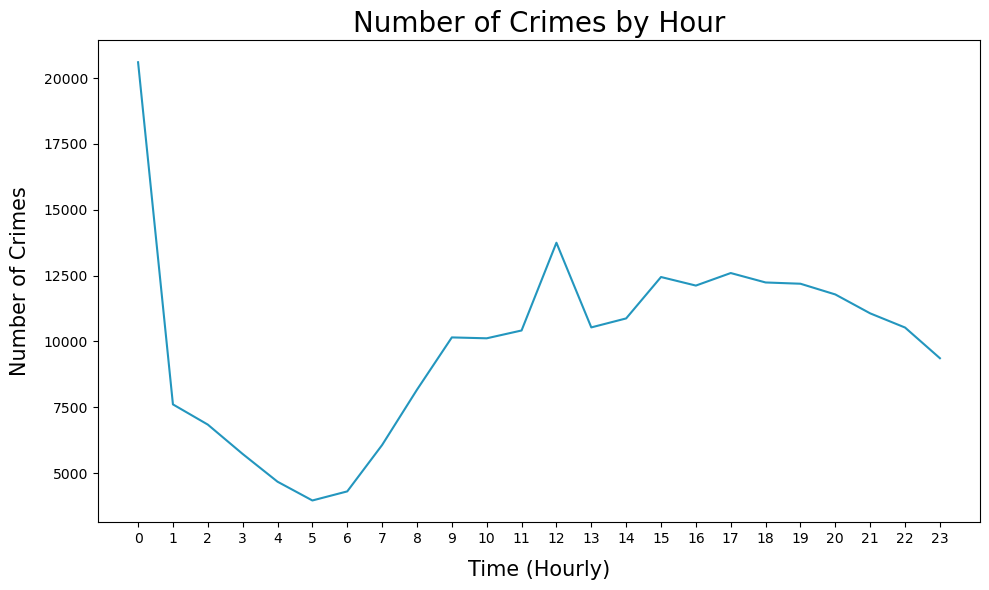

In [111]:

# Round times down to nearest hour
time_data['hourly_time'] = time_data['Date'].dt.floor('H').dt.time

crime_counts = time_data['hourly_time'].value_counts().sort_index()
crime_counts = crime_counts.to_frame(name = 'Count').reset_index()

plt.figure(figsize=(10, 6))
bx = sns.lineplot(x= crime_counts.index, y=crime_counts.Count, color = "#2396be")
step = len(crime_counts.index) // 24 
plt.xticks(range(0, len(crime_counts.index), step))
plt.xlabel('Time (Hourly)', fontsize = 15, labelpad=10)
plt.ylabel('Number of Crimes', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Hour', fontsize = 20)
plt.tight_layout()
plt.show()

### Analysis 2
*By \<Name of person doing the analysis>*

### Analysis 3
*By \<Name of person doing the analysis>*

### Analysis 4
*By \<Paisley Lucier>*

#### 1st visualization

In [112]:
# Visualizing proportion of crimes resulting in arrest across side
grouped_sides = arrest_data.groupby(['Side'])
grouped_sides_m = grouped_sides.mean()
grouped_sides_m

,ID,Arrest,Domestic,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Latitude,Longitude
Side,,,,,,,,,,,,
Central,1.273337e+07,0.107993,0.164096,813.361489,7.901587,18.560827,38.129553,1.169315e+06,1.883294e+06,2022.0,41.835260,-87.654221
North,1.274061e+07,0.131305,0.166681,1798.788545,17.753468,35.142533,19.727479,1.151533e+06,1.919441e+06,2022.0,41.934816,-87.718521
South,1.270866e+07,0.108861,0.260033,791.395471,7.690781,14.362799,57.593862,1.178853e+06,1.846025e+06,2022.0,41.732781,-87.620367


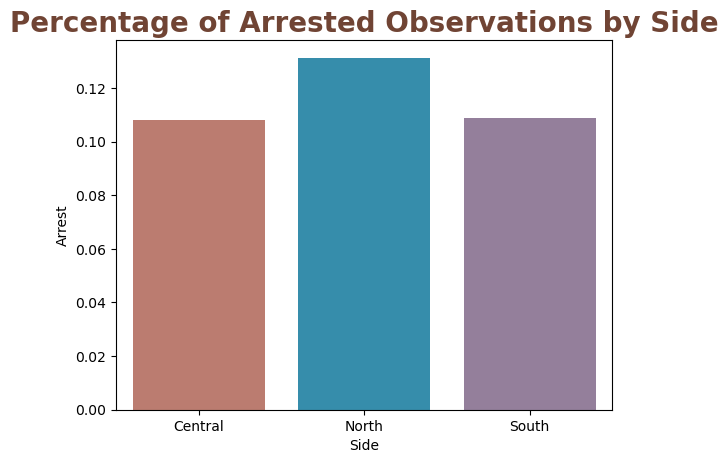

In [113]:
ax = sns.barplot(data=grouped_sides_m, x=grouped_sides_m.index, y='Arrest')
ax.set_title("Percentage of Arrested Observations by Side",
                  fontdict = {'fontsize': 20,
                              'fontweight': 'bold',
                              'color': '#704434'})
plt.show()

#### 2nd visualization


In [114]:
# to ensure that I am not comparing districts with almost 0 observances for a particular crime type, 
# I subset the top 12 crimes with the most overall observations

# be sure to show where this is coming from !!

In [115]:
# Subset top 12 crimes
top_12_crimes = arrest_data.loc[((arrest_data['Primary Type'] == 'THEFT') | \
                               (arrest_data['Primary Type'] == 'BATTERY') | \
                               (arrest_data['Primary Type'] == 'CRIMINAL DAMAGE') | \
                               (arrest_data['Primary Type'] == 'MOTOR VEHICLE THEFT') | \
                               (arrest_data['Primary Type'] == 'ASSAULT') | \
                               (arrest_data['Primary Type'] == 'DECEPTIVE PRACTICE') | \
                               (arrest_data['Primary Type'] == 'OTHER OFFENSE') | \
                               (arrest_data['Primary Type'] == 'ROBBERY') | \
                               (arrest_data['Primary Type'] == 'WEAPONS VIOLATION') | \
                               (arrest_data['Primary Type'] == 'BURGLARY') | \
                               (arrest_data['Primary Type'] == 'NARCOTICS') | \
                               (arrest_data['Primary Type'] == 'CRIMINAL TRESPASS')), :]

In [116]:
# Group observations by side, get average arrest rate for each top 12 crime type by side
grouped_side_type = top_12_crimes.groupby(['Side', 'Primary Type'])
grouped_side_type_m = grouped_side_type.mean().loc[:, 'Arrest']
grouped_side_type_m = grouped_side_type_m.reset_index() 

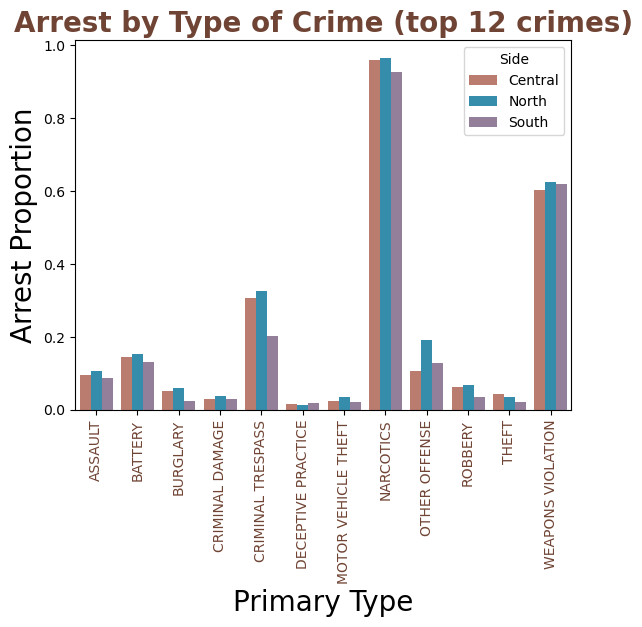

In [117]:
ax = sns.barplot(x='Primary Type',y='Arrest', hue='Side', data = grouped_side_type_m)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontdict = {
                              'color': '#704434'})
ax.set_title("Arrest by Type of Crime (top 12 crimes)",
                  fontdict = {'fontsize': 20,
                              'fontweight': 'bold',
                              'color': '#704434'})
ax.set_xlabel('Primary Type', fontsize=20)
ax.set_ylabel('Arrest Proportion', fontsize=20)

plt.show()

#### 3rd visualization

In [128]:
# Group by district
sentiments_2022_m = sentiments_2022.groupby(['DISTRICT']).mean()
sentiments_2022_m = sentiments_2022_m.reset_index()

# Add side column
sentiments_2022_m['Side'] = sentiments_2022_m['DISTRICT']
sentiments_2022_m['Side'] = sentiments_2022_m['Side'].map({4: 'South', 5: 'South', 6: 'South', 7: 'South', 22: 'South', 31: 'South', \
                       11: "North", 14: 'North', 15: 'North', 16: 'North', 17: 'North', 19: 'North', 20: 'North',\
                       24: 'North', 25: 'North', 1: 'Central', 2: 'Central', 3: 'Central', 8: 'Central', \
                        9: 'Central', 10: 'Central', 12: 'Central', 13: 'Central', 18: 'Central'})

In [129]:
# Group by side
sentiments_2022_m_side = sentiments_2022_m.groupby(['Side']).mean()
sentiments_2022_m_side = sentiments_2022_m_side.reset_index()
sentiments_2022_m_side.drop(columns='DISTRICT', inplace=True)

In [130]:
sentiments_2022_m_side_melted = pd.melt(sentiments_2022_m_side,id_vars = ['Side'],var_name = 'Survey_q',value_name = 'Score')


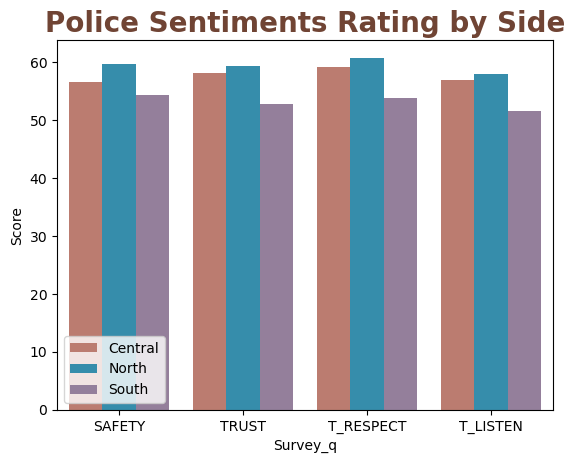

In [131]:
ax = sns.barplot(data=sentiments_2022_m_side_melted, x='Survey_q', y='Score', hue='Side')

ax.set_title("Police Sentiments Rating by Side",
                  fontdict = {'fontsize': 20,
                              'fontweight': 'bold',
                              'color': '#704434'})

plt.legend(loc='lower left')
plt.show()

#### 4th visualization

In [132]:
sentiments_arrest_dis = sentiments_2022_m.copy()
sentiments_arrest_dis = sentiments_arrest_dis.set_index('DISTRICT')
grouped = pd.DataFrame(top_12_crimes.groupby(['District', 'Primary Type']).mean().loc[:, 'Arrest'])
sentiments_arrest_dis.corr()

,SAFETY,TRUST,T_RESPECT,T_LISTEN
SAFETY,1.000000,0.915864,0.910727,0.914462
TRUST,0.915864,1.000000,0.996664,0.995943
T_RESPECT,0.910727,0.996664,1.000000,0.985276
T_LISTEN,0.914462,0.995943,0.985276,1.000000


In [133]:
# since these are highly correlated, I will aggregate to one score: average sentiment rating
sentiments_arrest_dis['avg_sent'] = (sentiments_arrest_dis['SAFETY'] + sentiments_arrest_dis['TRUST'] + \
                                    sentiments_arrest_dis['T_RESPECT'] + sentiments_arrest_dis['T_LISTEN']) / 4
sentiments_arrest_dis = sentiments_arrest_dis.drop(columns=['SAFETY', 'TRUST', 'T_RESPECT', 'T_LISTEN'])
sentiments_arrest_dis

,Side,avg_sent
DISTRICT,,
1.0,Central,60.353594
2.0,Central,56.393281
3.0,Central,50.658646
4.0,South,52.999375
5.0,South,51.750729
6.0,South,50.812396
7.0,South,50.670885
8.0,Central,60.179896
9.0,Central,57.743646


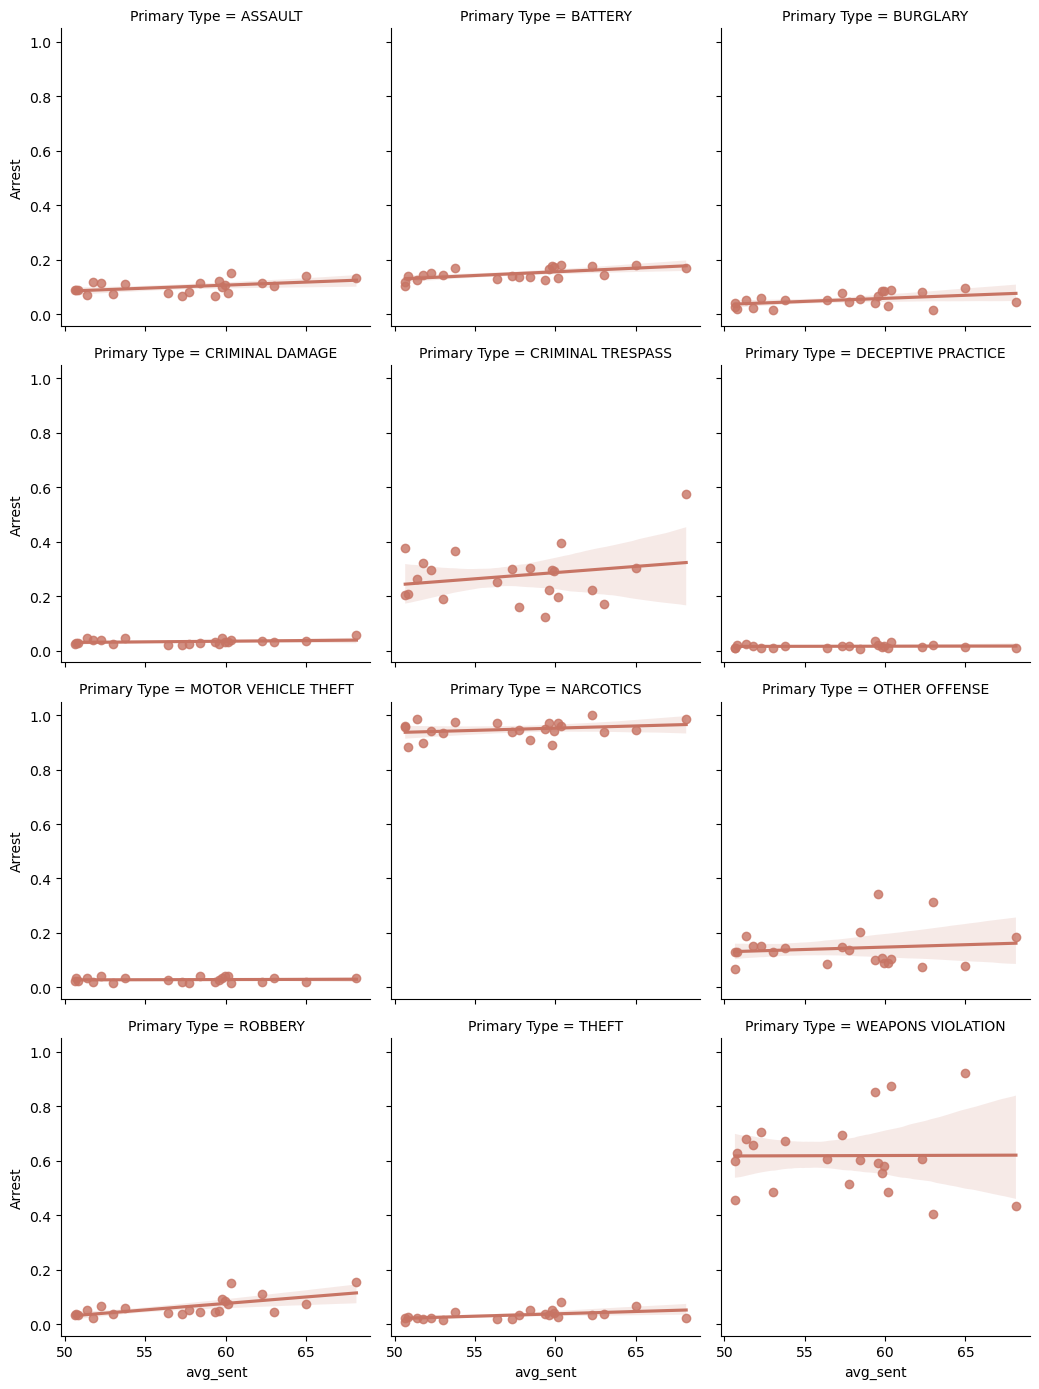

In [136]:
grouped = pd.DataFrame(top_12_crimes.groupby(['District', 'Primary Type']).mean().loc[:, 'Arrest'])

def merge_sentiments(x):
    x = pd.merge(left=x, right=sentiments_arrest_dis.reset_index(), left_on='District', right_on='DISTRICT')
    return x


grouped_new = grouped.reset_index().groupby('Primary Type').apply(merge_sentiments)
a = sns.FacetGrid(grouped_new, \
                  col = 'Primary Type',col_wrap=3,height=3.5,aspect = 1)
a.map_dataframe(sns.regplot,x="avg_sent", y="Arrest")
plt.show()

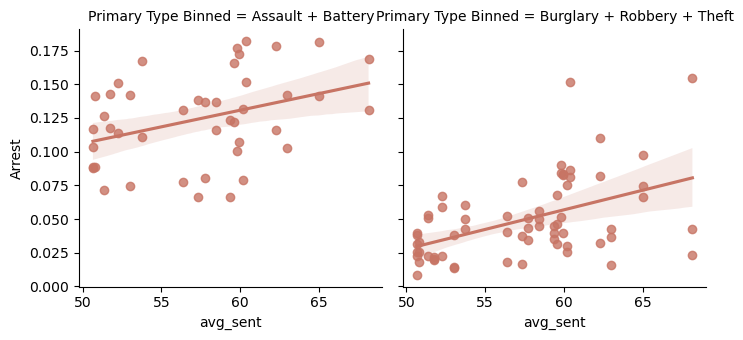

In [137]:
# binning the two types of crime with the most visible associations and graphing those for a closer look
grouped_new['Primary Type Binned'] = "None"
def bin_it(x):
    if (x['Primary Type'] == 'ASSAULT' or x['Primary Type'] == 'BATTERY'):
        x['Primary Type Binned'] = "Assault + Battery"
    elif (x['Primary Type'] == 'BURGLARY' or x['Primary Type'] == 'ROBBERY' or x['Primary Type'] == 'THEFT'):
        x['Primary Type Binned'] = "Burglary + Robbery + Theft"
    else:
        x['Primary Type Binned'] = x['Primary Type']
    return x
    
grouped_new = grouped_new.apply(bin_it, axis=1)
grouped_new = grouped_new.drop(columns = 'Primary Type')
grouped_new.reset_index()
grouped_new.groupby('Primary Type Binned')

a = sns.FacetGrid(grouped_new.loc[(grouped_new['Primary Type Binned']== 'Assault + Battery') \
                                  | (grouped_new['Primary Type Binned'] == 'Burglary + Robbery + Theft')], \
                  col = 'Primary Type Binned',col_wrap=3,height=3.5,aspect = 1)
a.map_dataframe(sns.regplot,x="avg_sent", y="Arrest")
plt.show()

#### 5th Visualization

In [138]:
grouped = pd.DataFrame(top_12_crimes.groupby(['Primary Type', 'District']).mean().loc[:, 'Arrest'])
grouped_reset = grouped.reset_index()

disparity_df = np.ones([grouped_reset['Primary Type'].nunique(), 4])
disparity_df = pd.DataFrame(disparity_df, columns=['Primary Type', 'District of Max Arrest Proportion', \
                                                   'District of Min Arrest Proportion', 'Difference'])
disparity_df['Primary Type'] = grouped_reset['Primary Type'].value_counts().index
disparity_df = disparity_df.set_index('Primary Type')

def get_disparity(x):
    maxx = x.Arrest.max()
    minn = x.Arrest.min()
    disparity_df.loc[x.loc[x['District'] == 1, 'Primary Type'], 'District of Max Arrest Proportion'] = x.loc[x.Arrest.idxmax(), 'District']
    disparity_df.loc[x.loc[x['District'] == 1, 'Primary Type'], 'District of Min Arrest Proportion'] = x.loc[x.Arrest.idxmin(), 'District']
    disparity_df.loc[x.loc[x['District'] == 1, 'Primary Type'], 'Difference'] = maxx - minn
    
grouped_reset.groupby('Primary Type').apply(get_disparity)

disparity_df.sort_values(by = 'Difference', ascending = False)

,District of Max Arrest Proportion,District of Min Arrest Proportion,Difference
Primary Type,,,
WEAPONS VIOLATION,18.0,17.0,0.516396
CRIMINAL TRESPASS,16.0,22.0,0.449882
OTHER OFFENSE,14.0,3.0,0.272351
ROBBERY,16.0,5.0,0.134063
NARCOTICS,19.0,6.0,0.116667
ASSAULT,1.0,12.0,0.085086
BURGLARY,18.0,4.0,0.083151
BATTERY,1.0,7.0,0.078671
THEFT,1.0,7.0,0.072987


## Other sections

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.